In [1]:
import gc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # https://stackoverflow.com/q/40426502/3178898
import pandas as pd
import numpy as np
import tensorflow as tf # https://github.com/tensorflow/tensorflow/issues/62075
tf.keras.utils.disable_interactive_logging() # https://stackoverflow.com/a/76863355/3178898
tf.keras.utils.set_random_seed(25)
if len(tf.config.list_physical_devices('GPU')) == 0: print('No GPU detected.')
import sklearn.model_selection as sel
import matplotlib.pyplot as plt

In [2]:
DATA_TRAIN = '.data/train.csv'
DATA_TEST_X = '.data/test.csv'
DATA_TEST_Y = '.data/revealed_targets.csv'

KAGGLE_DATA_TRAIN = '/kaggle/input/optiver-trading-at-the-close/train.csv'
KAGGLE_DATA_TEST_X = '/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv'
KAGGLE_DATA_TEST_Y = '/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv'

DROPS = ['index', 'time_id', 'currently_scored', 'time_id_x', 'time_id_y', 'revealed_date_id', 'revealed_time_id', 'row_id']
SORTS = ['date_id', 'stock_id', 'seconds_in_bucket'] # order matters here
SKIPS = ['imbalance_buy_sell_flag'] # some columns can skip normalization

def preprocess(data:pd.DataFrame) -> pd.DataFrame: # separate from load_data() for submission compat
    data = data.set_index(SORTS).sort_index()      # using a multi-index over row_id solves problems here and during training
    skip = data[[col for col in ['target', *SKIPS] if col in data.columns]]
    data = data.drop([col for col in [*DROPS, *SKIPS, 'target'] if col in data.columns], axis=1)
    data = data.groupby(level='stock_id').ffill()  # impute with last observation; groupby() ensures ffill() is per-stock, per-day
    data = (data - data.mean()) / data.std()       # normalize
    data = data.fillna(0)                          # clean columns that didn't ffill or with a stdev of 0 (i.e., unique() == 1)
    data = pd.concat([skip, data], axis=1, join='inner') # re-join with skipped columns
    temp = data.index.to_frame().seconds_in_bucket # encode seconds portion of index as sin/cos waves
    data['seconds_in_bucket_sin'] = np.sin((temp * 2 * np.pi / 540))
    data['seconds_in_bucket_cos'] = np.cos((temp * 2 * np.pi / 540))
    return data

def load_data(test:bool=False) -> pd.DataFrame: # returns training (or test) data for either local or kaggle setup.
    def read_data(train, test_x, test_y):
        if test:
            data = pd.merge(*[pd.read_csv(path) for path in [test_x, test_y]], on=SORTS)
            data = data.rename(columns={'revealed_target':'target'}) # QOL
        else:
            data = pd.read_csv(train)
        return data
    try:
        data = read_data(DATA_TRAIN, DATA_TEST_X, DATA_TEST_Y)
    except FileNotFoundError:
        data = read_data(KAGGLE_DATA_TRAIN, KAGGLE_DATA_TEST_X, KAGGLE_DATA_TEST_Y)
    data = data.dropna(subset=['target']) # some rows have null targets
    data = preprocess(data)
    return data

In [3]:
data = load_data()
data

target  imbalance_buy_sell_flag  \
date_id stock_id seconds_in_bucket                                      
0       0        0                 -3.029704                        1   
                 10                 0.389814                        1   
                 20                 4.220009                        1   
                 30                 5.450249                        1   
                 40                 3.169775                        1   
...                                      ...                      ...   
480     199      500               -7.209778                       -1   
                 510               -9.750128                       -1   
                 520                3.629923                       -1   
                 530                4.760027                       -1   
                 540               -6.530285                       -1   

                                    imbalance_size  reference_price  \
date_id stock_id seconds_in_bucket                                    
0       0        0                       -0.123543        -0.072500   
                 10                      -0.215221         0.012001   
                 20                      -0.215221        -0.030249   
                 30                      -0.215221         0.054252   
                 40                      -0.219197         0.181399   
...                                            ...              ...   
480     199      500                     -0.148832         1.093144   
                 510                     -0.148972         1.093144   
                 520                     -0.212648         0.717232   
                 530                     -0.212648         0.717232   
                 540                     -0.186730         0.842404   

                                    matched_size  far_price  near_price  \
date_id stock_id seconds_in_bucket                                        
0       0        0                     -0.226825   0.000000    0.000000   
                 10                    -0.213375   0.000000    0.000000   
                 20                    -0.213375   0.000000    0.000000   
                 30                    -0.213375   0.000000    0.000000   
                 40                    -0.212792   0.000000    0.000000   
...                                          ...        ...         ...   
480     199      500                   -0.151103   0.000134    0.191721   
                 510                   -0.151083   0.000134    0.191721   
                 520                   -0.151038   0.000134    0.191721   
                 530                   -0.151038   0.000134    0.191721   
                 540                   -0.150356   0.000134    0.191721   

                                    bid_price  bid_size  ask_price  ask_size  \
date_id stock_id seconds_in_bucket                                             
0       0        0                   0.034269  0.079311  -0.095044 -0.348522   
                 10                  0.034269 -0.339411  -0.095044 -0.232361   
                 20                  0.034269 -0.423156  -0.137672 -0.320394   
                 30                  0.119891  0.037547  -0.052415 -0.057000   
                 40                  0.205914 -0.333493   0.075869 -0.208464   
...                                       ...       ...        ...       ...   
480     199      500                 1.215378  0.632116   1.122462  2.873609   
                 510                 1.215378  5.611071   1.122462  2.270413   
                 520                 0.834478  1.557565   0.742788  1.090429   
                 530                 0.834478  2.097829   0.742788  1.244135   
                 540                 0.961311  1.779422   0.869479  1.906292   

                                         wap  seconds_in_bucket_sin  \
date_id stock_id seconds_in_bucket                                    
0    

In [4]:
test = load_data(test=True)
test

target  imbalance_buy_sell_flag  \
date_id stock_id seconds_in_bucket                                       
478     0        0                  -2.310276                       -1   
                 10                 -7.200241                       -1   
                 20                 -7.500052                       -1   
                 30                -12.480021                       -1   
                 40                 -9.570122                       -1   
...                                       ...                      ...   
480     199      500                -4.659891                       -1   
                 510                -4.739761                       -1   
                 520                -5.440116                       -1   
                 530                -8.689761                       -1   
                 540                -7.609725                       -1   

                                    imbalance_size  reference_price  \
date_id stock_id seconds_in_bucket                                    
478     0        0                       -0.156132        -0.145819   
                 10                      -0.155172        -0.053244   
                 20                      -0.155172        -0.053244   
                 30                      -0.138401         0.038802   
                 40                      -0.140299         0.038802   
...                                            ...              ...   
480     199      500                     -0.215242         1.382460   
                 510                     -0.215398         1.382460   
                 520                     -0.286133         0.878853   
                 530                     -0.286133         0.878853   
                 540                     -0.257341         1.046546   

                                    matched_size  far_price  near_price  \
date_id stock_id seconds_in_bucket                                        
478     0        0                     -0.232670   0.000000     0.00000   
                 10                    -0.232658   0.000000     0.00000   
                 20                    -0.232658   0.000000     0.00000   
                 30                    -0.232726   0.000000     0.00000   
                 40                    -0.232519   0.000000     0.00000   
...                                          ...        ...         ...   
480     199      500                   -0.159399   0.097682     0.22115   
                 510                   -0.159382   0.097682     0.22115   
                 520                   -0.159345   0.097682     0.22115   
                 530                   -0.159345   0.097682     0.22115   
                 540                   -0.158782   0.097682     0.22115   

                                    bid_price  bid_size  ask_price  ask_size  \
date_id stock_id seconds_in_bucket                                             
478     0        0                  -0.020897 -0.387010  -0.193735 -0.405173   
                 10                  0.069723 -0.441980  -0.099185 -0.318402   
                 20                  0.069723 -0.598206  -0.099185 -0.176504   
                 30                  0.159825 -0.317609  -0.004091 -0.363790   
                 40                  0.159825 -0.413892  -0.004091 -0.288369   
...                                       ...       ...        ...       ...   
480     199      500                 1.475103  0.565352   1.453832  2.535443   
                 510                 1.475103  5.885641   1.453832  1.984041   
                 520                 0.982133  1.554245   0.935979  0.905381   
                 530                 0.982133  2.131547   0.935979  1.045888   
                 540                 1.146283  1.791311   1.108778  1.651187   

                                         wap  seconds_in_bucket_sin  \
date_id stock_id seconds_in_bucket                              

In [5]:
WINDOW_SIZE = 1

class WindowGenerator: # https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing
    def __init__(self, train:pd.DataFrame=None, valid:pd.DataFrame=None, _test:pd.DataFrame=None) -> None:
        self._train = train
        self._valid = valid
        self._test = _test
        columns = train.columns if train is not None else _test.columns # we're either training or testing
        self._column_indices = {name: i for i, name in enumerate(columns)}
        self._input_slice = slice(0, WINDOW_SIZE)
        self._label_slice = slice(WINDOW_SIZE - 1, None)
        indices = np.arange(WINDOW_SIZE)
        self._input_indices = indices[self._input_slice]
        self._label_indices = indices[self._label_slice]
        del indices
    
    def __repr__(self) -> str:
        return '\n'.join([f'Window size: {WINDOW_SIZE}', f'Input indices: {self._input_indices}', f'Label indices: {self._label_indices}'])
    
    def split_features(self, features:tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]: # [batch, time, features]
        inputs = features[:, self._input_slice, :]
        inputs = tf.stack([inputs[:, :, self._column_indices[col]] for col in self._column_indices if col != 'target'], axis=-1)
        inputs.set_shape([None, WINDOW_SIZE, None])
        try:
            labels = features[:, self._label_slice, :]
            labels = tf.stack([labels[:, :, self._column_indices['target']]], axis=-1)
            labels.set_shape([None, 1, None])
        except KeyError: # we don't have target on submission and try/catch is faster than an if statement
            labels = None
        return inputs, labels
    
    def make_dataset(self, df:pd.DataFrame) -> tf.data.Dataset:
        data = np.array(df, dtype=np.float32)
        data = tf.keras.utils.timeseries_dataset_from_array(data=data, targets=None, sequence_length=WINDOW_SIZE, shuffle=True, batch_size=32)
        data = data.map(self.split_features)
        return data
    
    @property
    def train(self) -> tf.data.Dataset:
        return self.make_dataset(self._train)
    
    @property
    def valid(self) -> tf.data.Dataset:
        return self.make_dataset(self._valid)
    
    @property
    def test(self) -> tf.data.Dataset:
        return self.make_dataset(self._test)

In [6]:
def compile_and_get_kw(model:tf.keras.Model, patience:int=2) -> dict: # returns kwargs for `model.fit()`
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min') # TODO: customize
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()]) # TODO: customize
    return dict(callbacks=[early_stop])

def fit_and_evaluate(models:list[tf.keras.Model], folds:int=5, _data:pd.DataFrame=data, _test:pd.DataFrame=test) -> pd.DataFrame:
    print(f'Training {len(models)} model(s) over {folds} folds. ETA: {len(models)*folds*2} minutes.')
    fit_kw = {m.name: compile_and_get_kw(m) for m in models}
    scores = [] # https://stackoverflow.com/a/17496530/3178898
    for i, (i_train, i_valid) in enumerate(sel.TimeSeriesSplit(folds).split(_data)):
        window = WindowGenerator(train=data.iloc[i_train, :], valid=data.iloc[i_valid, :], _test=_test)
        for j, m in enumerate(models):
            print(f'Fold {i+1}/{folds}: Training Model {j+1}/{len(models)}: {m.name}'+' '*32, end='\r')
            m.fit(window.train, validation_data=window.valid, **fit_kw[m.name])
            mse, mae = m.evaluate(window.test)
            scores.append({'model': m.name, 'fold': i+1, 'mse': mse, 'mae': mae})
        print(f'Fold {i+1}/{folds}: Complete'+' '*32)
    scores = pd.DataFrame(scores).set_index(['model', 'fold']).sort_index(level=0)
    return scores

In [7]:
nn = tf.keras.Sequential
layers = tf.keras.layers
models = [
    nn([layers.Dense(1)], name='linear'), # baseline
    # nn([layers.LSTM(16, return_sequences=True), layers.Dense(1)], name='rnn16'),
    # nn([layers.LSTM(32, return_sequences=True), layers.Dense(1)], name='rnn32'),
    # nn([layers.LSTM(64, return_sequences=True), layers.Dense(1)], name='rnn64'),
]
scores = fit_and_evaluate(models, 2)
scores

Training 1 model(s) over 2 folds. ETA: 4 minutes.


I0000 00:00:1701280667.856259   18981 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Fold 1/2: Complete                                
Fold 2/2: Complete                                                  


mse       mae
model  fold                     
linear 1     65.306671  5.431634
       2     65.576675  5.444225

In [8]:
model = models[-1]

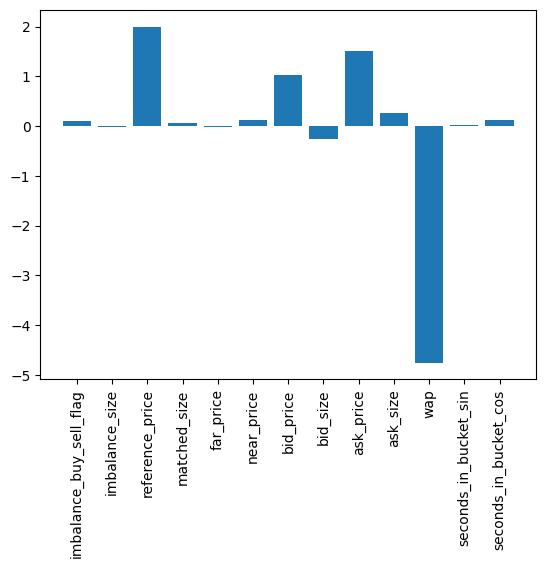

In [13]:
_cols = data.drop('target', axis=1).columns
ticks = range(len(_cols))
plt.bar(x=ticks, height=model.layers[0].kernel[:,0].numpy())
plt.xticks(ticks=ticks, labels=_cols, rotation=90)
pass

In [ ]:
# raise Exception # hard stop for manual eval

In [14]:
# submission compat check
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

for i, (_test, _, _) in enumerate(iter_test):
    X_test = preprocess(_test)
    window = WindowGenerator(_test=X_test)
    y_pred = model.predict(window.test, verbose=0)[:, -1, :]
    y_pred = np.insert(y_pred, 0, [0]*(WINDOW_SIZE-1)) # model has a warm-up period so we prepend with 0's
    submission = pd.DataFrame(columns=['target'], index=X_test.index)
    submission['target'] = y_pred
    submission.reset_index(inplace=True) # break out SORTS to recreate row_id for submission
    submission['row_id'] = submission.apply(lambda x : f'{x.date_id:.0f}_{x.seconds_in_bucket:.0f}_{x.stock_id:.0f}', axis=1)
    submission = submission.drop(SORTS, axis=1)
    env.predict(submission)

In [15]:
try:
    res = pd.read_csv('/kaggle/working/submission.csv') # sanity check
except FileNotFoundError:
    res = pd.read_csv('./.data/submission.csv')
res

,target,row_id
0,-1.116165,478_0_0
1,-1.101818,478_0_1
2,-0.323660,478_0_2
3,-1.283417,478_0_3
4,4.361825,478_0_4
...,...,...
32995,-0.094207,480_540_195
32996,0.398752,480_540_196
32997,0.169335,480_540_197
32998,0.246272,480_540_198
